In [2]:
import torch
import triton
import triton.language as tl

# Define the kernel with auto-tuning for AMD MI325X configurations.
# CDNA 3 benefits from larger block sizes and moderate warp counts.
@triton.autotune(
    configs=[
        # Config 1: Large tile, high concurrency. Good for large matrices.
        triton.Config({'BLOCK_M': 256, 'BLOCK_N': 128, 'BLOCK_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        # Config 2: Balanced tile. Often the sweet spot for MFMA instructions.
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 128, 'BLOCK_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
        # Config 3: Smaller tile for better occupancy on smaller batches.
        triton.Config({'BLOCK_M': 128, 'BLOCK_N': 64,  'BLOCK_K': 64,  'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        # Config 4: High K-blocking to feed the tensor cores longer.
        triton.Config({'BLOCK_M': 64,  'BLOCK_N': 128, 'BLOCK_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
def fp8_gemm_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Pointers to quantization scales (scalar or vector)
    a_scale_ptr, b_scale_ptr,
    # Matrix dimensions
    M, N, K,
    # Strides (Row-major assumed: stride_ak=1, stride_bk=1 usually for optimal load)
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
):
    """
    Computes C = (scale_a * A_fp8) x (scale_b * B_fp8)
    Input: A, B in FP8 (e4m3 or e5m2)
    Output: C in BF16 or FP16 (accumulated in FP32)
    """
    
    # -----------------------------------------------------------
    # 1. Map Program ID to Block Coordinate
    # -----------------------------------------------------------
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_M)
    num_pid_n = tl.cdiv(N, BLOCK_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # -----------------------------------------------------------
    # 2. Setup Memory Pointers
    # -----------------------------------------------------------
    # Create pointers for the first block of A and B
    # A is usually [M, K], B is usually [K, N] (transposed in memory usually helps, strictly K-major)
    
    # Range for A rows [0..BLOCK_M]
    offs_am = (pid_m * BLOCK_M + tl.arange(0, BLOCK_M)) % M
    # Range for B cols [0..BLOCK_N]
    offs_bn = (pid_n * BLOCK_N + tl.arange(0, BLOCK_N)) % N
    # Range for K dimension [0..BLOCK_K]
    offs_k = tl.arange(0, BLOCK_K)

    # Pointer arithmetic
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # 3. Load Scales (Quantization)
    # -----------------------------------------------------------
    # Assuming per-tensor quantization for simplicity (scalar load). 
    # If per-row/col, you would load vectors based on offs_am / offs_bn.
    scale_a = tl.load(a_scale_ptr)
    scale_b = tl.load(b_scale_ptr)
    
    # Accumulator (MFMA accumulates in F32)
    accumulator = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)

    # -----------------------------------------------------------
    # 4. Main Loop (K-Dimension)
    # -----------------------------------------------------------
    for k in range(0, tl.cdiv(K, BLOCK_K)):
        # Load the next blocks of A and B
        # Masking is required if K is not a multiple of BLOCK_K, 
        # but for performance we usually pad K to be a multiple of BLOCK_K.
        # Here we assume padded K for raw speed (no 'mask=' argument).
        
        a = tl.load(a_ptrs)
        b = tl.load(b_ptrs)
        
        # We perform the Dot Product. 
        # Triton detects that inputs are FP8 (e.g. float8e4nv) and 
        # maps this to the CDNA 3 `mfma_f32_32x32x16_fp8_fp8` instruction.
        accumulator = tl.dot(a, b, accumulator)

        # Advance pointers to the next K-block
        a_ptrs += BLOCK_K * stride_ak
        b_ptrs += BLOCK_K * stride_bk

    # -----------------------------------------------------------
    # 5. Epilogue: Scaling & Store
    # -----------------------------------------------------------
    # Convert accumulator to result type (e.g., float16 or bfloat16)
    c = accumulator.to(tl.float32)
    
    # Apply Quantization Scales (Dequantize)
    # C = (A_scaled * B_scaled) = (A_raw * s_a) * (B_raw * s_b) = Acc * s_a * s_b
    total_scale = scale_a * scale_b
    c = c * total_scale

    # Store result
    # We use a mask for M/N in case matrix dims aren't perfect multiples of BLOCK sizes
    offs_cm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_cn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    
    # Cast to output format (BF16 is standard for AI on MI300/325)
    tl.store(c_ptrs, c.to(tl.bfloat16), mask=c_mask)


# -------------------------------------------------------------------------
# 2. Wrapper Function
# -------------------------------------------------------------------------
def triton_fp8_matmul(a_fp8, b_fp8, scale_a, scale_b):
    """
    a_fp8: (M, K)
    b_fp8: (K, N)  <- Note: In memory, usually stored (N, K) for efficient loads, 
                      but for simplicity here we assume standard (K,N) or handle strides.
    """
    M, K = a_fp8.shape
    K_b, N = b_fp8.shape
    assert K == K_b, "Matrix dimensions mismatch"

    # Allocate output
    c = torch.empty((M, N), device=a_fp8.device, dtype=torch.bfloat16)
    
    # Grid definition
    grid = lambda META: (triton.cdiv(M, META['BLOCK_M']) * triton.cdiv(N, META['BLOCK_N']), )

    # Launch kernel
    # NOTE: We assume 'b_fp8' is Column-Major (standard PyTorch layout is Row-Major).
    # If B is (K, N) Row-Major: stride_bk=N, stride_bn=1
    # For optimal performance, B should be (N, K) in memory (Transposed), 
    # so reading a column of B is contiguous.
    # Here we simply pass the strides PyTorch gives us.
    fp8_gemm_kernel[grid](
        a_fp8, b_fp8, c,
        scale_a, scale_b,
        M, N, K,
        a_fp8.stride(0), a_fp8.stride(1),
        b_fp8.stride(0), b_fp8.stride(1),
        c.stride(0), c.stride(1)
    )
    return c

# -------------------------------------------------------------------------
# 3. Unit Test: Numerical Verification
# -------------------------------------------------------------------------
def test_correctness():
    torch.manual_seed(0)
    # Dimensions (Multiples of 128 are best for Triton)
    M, N, K = 1024, 1024, 1024
    
    # Use AMD-specific FP8 type if available, else standard e4m3
    fp8_dtype = torch.float8_e4m3fnuz if hasattr(torch, 'float8_e4m3fnuz') else torch.float8_e4m3fn
    print(f"Testing with dtype: {fp8_dtype}")

    # 1. Prepare Inputs (BF16)
    a_bf16 = torch.randn((M, K), device='cuda', dtype=torch.bfloat16)
    b_bf16 = torch.randn((K, N), device='cuda', dtype=torch.bfloat16)

    # 2. Mock Quantization (Per-Tensor)
    # Calculate simple max-based scale
    scale_a_val = a_bf16.abs().max().item() / 240.0 # 240 is approx max range for e4m3
    scale_b_val = b_bf16.abs().max().item() / 240.0
    
    scale_a = torch.tensor(scale_a_val, device='cuda', dtype=torch.float32)
    scale_b = torch.tensor(scale_b_val, device='cuda', dtype=torch.float32)

    # Quantize to FP8
    a_fp8 = (a_bf16 / scale_a).to(fp8_dtype)
    b_fp8 = (b_bf16 / scale_b).to(fp8_dtype)

    # 3. Reference Implementation (Torch High Precision)
    # We "dequantize" the FP8 inputs back to BF16 to see exactly what the GPU sees,
    # then matmul in BF16. This isolates kernel logic errors from quantization noise.
    a_ref = a_fp8.to(torch.bfloat16)
    b_ref = b_fp8.to(torch.bfloat16)
    c_ref = torch.matmul(a_ref, b_ref) * (scale_a * scale_b)

    # 4. Triton Implementation
    c_tri = triton_fp8_matmul(a_fp8, b_fp8, scale_a, scale_b)

    # 5. Compare
    # Tolerances: FP8 has low precision. We expect some deviation.
    # Comparing against the 'simulated' reference (a_ref @ b_ref) handles quantization noise.
    # If the kernel is correct, it should match closely.
    print(f"Ref Stats  - Max: {c_ref.max().item():.4f}, Min: {c_ref.min().item():.4f}, Mean: {c_ref.abs().mean().item():.4f}")
    print(f"Tri Stats  - Max: {c_tri.max().item():.4f}, Min: {c_tri.min().item():.4f}, Mean: {c_tri.abs().mean().item():.4f}")

    # Check if Triton output is all zeros
    if c_tri.abs().max().item() == 0:
        print("⚠️ WARNING: Triton output is all zeros! Kernel might not be writing.")

    diff = (c_ref - c_tri).abs().max()
    print(f"Max Difference: {diff.item()}")
    
    # Note: FP8 matmul accumulation order on hardware might differ from PyTorch BF16 matmul,
    # so we use a loose tolerance (atol=1e-1 or similar depending on magnitude).
    torch.testing.assert_close(c_tri, c_ref, atol=0.0002, rtol=0.01)
    print("✅ Unit Test Passed!")

# -------------------------------------------------------------------------
# 4. Benchmark Script
# -------------------------------------------------------------------------
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['M', 'N', 'K'], 
        x_vals=[1024, 2048, 4096, 8192], 
        line_arg='provider', 
        line_vals=['torch-bf16', 'triton-fp8'], 
        line_names=['PyTorch (BF16)', 'Triton (FP8)'],
        styles=[('green', '-'), ('blue', '-')], 
        ylabel='TFLOPS', 
        plot_name='fp8-gemm-performance',
        args={}
    )
)
def benchmark(M, N, K, provider):
    # Setup
    fp8_dtype = torch.float8_e4m3fnuz if hasattr(torch, 'float8_e4m3fnuz') else torch.float8_e4m3fn
    
    a_fp8 = torch.randn((M, K), device='cuda', dtype=torch.float16).to(fp8_dtype)
    b_fp8 = torch.randn((K, N), device='cuda', dtype=torch.float16).to(fp8_dtype)
    scale_a = torch.tensor(1.0, device='cuda', dtype=torch.float32)
    scale_b = torch.tensor(1.0, device='cuda', dtype=torch.float32)
    
    # For PyTorch baseline, we use BF16 (Standard "High Perf" baseline)
    a_bf16 = torch.randn((M, K), device='cuda', dtype=torch.bfloat16)
    b_bf16 = torch.randn((K, N), device='cuda', dtype=torch.bfloat16)
    
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == 'torch-bf16':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a_bf16, b_bf16), quantiles=quantiles)
    if provider == 'triton-fp8':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_fp8_matmul(a_fp8, b_fp8, scale_a, scale_b), quantiles=quantiles)
        
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


In [3]:
test_correctness()

Testing with dtype: torch.float8_e4m3fnuz
Ref Stats  - Max: 165.0000, Min: -157.0000, Mean: 25.6250
Tri Stats  - Max: 165.0000, Min: -156.0000, Mean: 25.6250
Max Difference: 1.0
✅ Unit Test Passed!


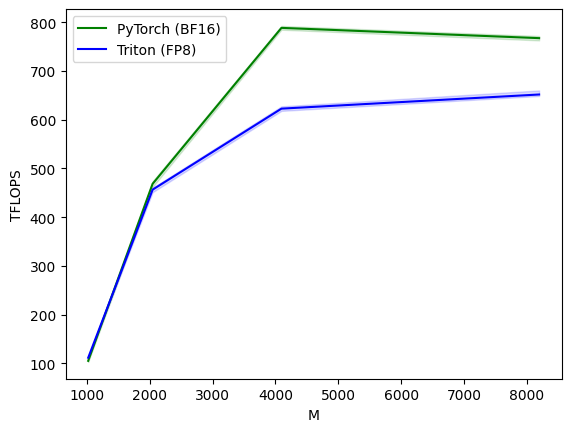

fp8-gemm-performance:
        M       N       K  PyTorch (BF16)  Triton (FP8)
0  1024.0  1024.0  1024.0      105.268802    111.621381
1  2048.0  2048.0  2048.0      468.371547    456.425835
2  4096.0  4096.0  4096.0      788.261761    622.580294
3  8192.0  8192.0  8192.0      767.194707    651.595634


In [4]:
benchmark.run(show_plots=True, print_data=True)

In [5]:
import torch
import triton

# Ensure you are on a ROCm system with MI300/MI325
# FP8 data types in PyTorch: torch.float8_e4m3fnuz (AMD standard) or e5m2

def run_fp8_gemm(M, N, K):
    # 1. Prepare Data
    # AMD MI300/325 often uses e4m3fnuz for weights/activations in inference
    dtype_input = torch.float8_e4m3fnuz 
    dtype_output = torch.bfloat16

    a = torch.randn((M, K), device='cuda', dtype=torch.float16).to(dtype_input)
    b = torch.randn((N, K), device='cuda', dtype=torch.float16).t().to(dtype_input) # B is KxN, stored as N,K (Col Major) or K,N?
    # NOTE: Optimal layout for GEMM is typically A=RowMajor, B=ColMajor (K is the inner dimension for both)
    # Triton loads row-major by default. If B is KxN, we want stride_bk=1. 
    # If B is NxK (transposed), we want stride_bn=1.
    
    # For this kernel code:
    # A is (M, K) Row Major -> stride_am=K, stride_ak=1
    # B is (K, N) Col Major -> stride_bk=1, stride_bn=K
    
    # Let's verify B layout. If we pass B as (K, N) contig:
    # b_ptr + k * stride_bk + n * stride_bn
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).to(dtype_input)

    c = torch.empty((M, N), device='cuda', dtype=dtype_output)
    
    scale_a = torch.tensor(0.5, device='cuda', dtype=torch.float32)
    scale_b = torch.tensor(0.5, device='cuda', dtype=torch.float32)

    # 2. Enqueue Kernel
    grid = lambda META: (triton.cdiv(M, META['BLOCK_M']) * triton.cdiv(N, META['BLOCK_N']), )
    
    fp8_gemm_kernel[grid](
        a, b, c,
        scale_a, scale_b,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1)
    )
    
    return c


In [6]:
# Example run
M, N, K = 4096, 4096, 4096
output = run_fp8_gemm(M, N, K)
output

tensor([[-18.7500,  -5.8750, -10.8750,  ..., -24.7500, -15.8750, -15.7500],
        [ 11.0625,  -6.5000,  -7.1250,  ...,  -0.6055,   5.5000, -15.9375],
        [ 24.8750, -34.5000,  20.8750,  ...,  -0.0815,   7.4688,  10.8125],
        ...,
        [-26.1250,  22.6250,  15.3750,  ...,  -9.5625, -11.7500,   8.8125],
        [ 18.5000, -16.3750,  11.5625,  ...,  -7.7188,  23.6250,  -1.5234],
        [ -2.9062,   6.0312, -25.1250,  ...,  14.0625,  22.8750,   9.2500]],
       device='cuda:0', dtype=torch.bfloat16)

In [9]:
import torch
import triton
import triton.language as tl
import transformer_engine.pytorch as te
from transformer_engine.pytorch.module.grouped_linear import GroupedLinear
from transformer_engine.common.recipe import Float8CurrentScaling, Format

# -------------------------------------------------------------------------
# Fused Grouped FP8 GEMM Kernel (Quantize + GEMM)
# -------------------------------------------------------------------------
# Feature Parity with Transformer Engine Current Scaling:
# 1. Inputs are BF16/FP16 (High Precision).
# 2. Kernel fuses Quantization (Scaling + Cast) with GEMM.
# 3. Scales are provided (calculated per-tensor on host/wrapper).
@triton.jit
def grouped_fused_fp8_gemm_kernel(
    # Arrays of Pointers (One per GEMM)
    a_ptr_list, b_ptr_list, c_ptr_list,
    # Scales for Quantization (BF16 -> FP8)
    a_qscale_ptr_list, b_qscale_ptr_list,
    # Scales for De-quantization (Accumulator -> BF16)
    a_dscale_ptr_list, b_dscale_ptr_list,
    # Arrays of Dimensions
    M_list, N_list, K_list,
    # Grid Scheduling Map
    grid_map_ptr,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr, BLOCK_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, 
):
    pid = tl.program_id(0)
    
    # --- 1. Scheduler / Swizzling ---
    map_offset = pid * 3
    gemm_id = tl.load(grid_map_ptr + map_offset)
    pid_m = tl.load(grid_map_ptr + map_offset + 1)
    pid_n = tl.load(grid_map_ptr + map_offset + 2)

    # --- 2. Load Metadata ---
    M = tl.load(M_list + gemm_id)
    N = tl.load(N_list + gemm_id)
    K = tl.load(K_list + gemm_id)
    
    # Inputs are now BF16 (High Precision)
    a_ptr = tl.load(a_ptr_list + gemm_id).to(tl.pointer_type(tl.bfloat16))
    b_ptr = tl.load(b_ptr_list + gemm_id).to(tl.pointer_type(tl.bfloat16))
    c_ptr = tl.load(c_ptr_list + gemm_id).to(tl.pointer_type(tl.bfloat16))
    
    # Scales
    qscale_a = tl.load(tl.load(a_qscale_ptr_list + gemm_id).to(tl.pointer_type(tl.float32)))
    qscale_b = tl.load(tl.load(b_qscale_ptr_list + gemm_id).to(tl.pointer_type(tl.float32)))
    dscale_a = tl.load(tl.load(a_dscale_ptr_list + gemm_id).to(tl.pointer_type(tl.float32)))
    dscale_b = tl.load(tl.load(b_dscale_ptr_list + gemm_id).to(tl.pointer_type(tl.float32)))

    # --- 3. Pointer Arithmetic ---
    offs_am = (pid_m * BLOCK_M + tl.arange(0, BLOCK_M)) % M
    offs_bn = (pid_n * BLOCK_N + tl.arange(0, BLOCK_N)) % N
    offs_k = tl.arange(0, BLOCK_K)

    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
   
    # --- 4. Main Loop (Fused Quantization + MMA) ---
    accumulator = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)

    for k in range(0, tl.cdiv(K, BLOCK_K)):
        a_bf16 = tl.load(a_ptrs)
        b_bf16 = tl.load(b_ptrs)
        
        # Fused Quantization: Scale + Cast to FP8
        # Using float8e4b8 (AMD E4M3FNUZ equivalent)
        a_fp8 = (a_bf16 * qscale_a).to(tl.float8e4b8)
        b_fp8 = (b_bf16 * qscale_b).to(tl.float8e4b8)
        
        accumulator = tl.dot(a_fp8, b_fp8, accumulator)
        
        a_ptrs += BLOCK_K * stride_ak
        b_ptrs += BLOCK_K * stride_bk

    # --- 5. Epilogue (Dequantization) ---
    total_dscale = dscale_a * dscale_b
    c = accumulator.to(tl.float32) * total_dscale
    
    offs_cm = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_cn = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    
    tl.store(c_ptrs, c.to(tl.bfloat16), mask=c_mask)

# -------------------------------------------------------------------------
# Python Wrapper: Triton Fused
# -------------------------------------------------------------------------
def run_fused_grouped_gemm(A_list, B_list):
    device = A_list[0].device
    BLOCK_M, BLOCK_N, BLOCK_K = 128, 128, 128
    GROUP_SIZE_M = 8 
    FP8_MAX = 240.0
    
    grid_map = [] 
    M_list, N_list, K_list = [], [], []
    A_ptr_list, B_ptr_list, C_ptr_list = [], [], []
    qscale_a_list, qscale_b_list = [], []
    dscale_a_list, dscale_b_list = [], []
    C_out_list = []
    holder_scales = [] 

    for idx, (A, B) in enumerate(zip(A_list, B_list)):
        M, K = A.shape
        _, N = B.shape
        C = torch.empty((M, N), device=device, dtype=torch.bfloat16)
        C_out_list.append(C)
        
        # Dynamic Current Scaling
        max_a = A.abs().max().float()
        max_b = B.abs().max().float()
        max_a = torch.maximum(max_a, torch.tensor(1e-6, device=device))
        max_b = torch.maximum(max_b, torch.tensor(1e-6, device=device))
        
        q_scale_a = (FP8_MAX / max_a)
        q_scale_b = (FP8_MAX / max_b)
        d_scale_a = 1.0 / q_scale_a
        d_scale_b = 1.0 / q_scale_b
        
        # Metadata
        M_list.append(M); N_list.append(N); K_list.append(K)
        A_ptr_list.append(A.data_ptr()); B_ptr_list.append(B.data_ptr()); C_ptr_list.append(C.data_ptr())
        
        qa_t = q_scale_a.clone(); qb_t = q_scale_b.clone()
        da_t = d_scale_a.clone(); db_t = d_scale_b.clone()
        holder_scales.extend([qa_t, qb_t, da_t, db_t])
        
        qscale_a_list.append(qa_t.data_ptr())
        qscale_b_list.append(qb_t.data_ptr())
        dscale_a_list.append(da_t.data_ptr())
        dscale_b_list.append(db_t.data_ptr())

        # Scheduling
        num_pid_m = triton.cdiv(M, BLOCK_M)
        num_pid_n = triton.cdiv(N, BLOCK_N)
        num_pid_in_group = GROUP_SIZE_M * num_pid_n
        total_tiles = num_pid_m * num_pid_n
        
        for pid in range(total_tiles):
            group_id = pid // num_pid_in_group
            first_pid_m = group_id * GROUP_SIZE_M
            group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
            pid_m = first_pid_m + (pid % group_size_m)
            pid_n = (pid % num_pid_in_group) // group_size_m
            grid_map.append([idx, pid_m, pid_n])

    d_grid_map = torch.tensor(grid_map, device=device, dtype=torch.int32)
    d_M = torch.tensor(M_list, device=device, dtype=torch.int32)
    d_N = torch.tensor(N_list, device=device, dtype=torch.int32)
    d_K = torch.tensor(K_list, device=device, dtype=torch.int32)
    d_Ap = torch.tensor(A_ptr_list, device=device, dtype=torch.int64)
    d_Bp = torch.tensor(B_ptr_list, device=device, dtype=torch.int64)
    d_Cp = torch.tensor(C_ptr_list, device=device, dtype=torch.int64)
    d_QSa = torch.tensor(qscale_a_list, device=device, dtype=torch.int64)
    d_QSb = torch.tensor(qscale_b_list, device=device, dtype=torch.int64)
    d_DSa = torch.tensor(dscale_a_list, device=device, dtype=torch.int64)
    d_DSb = torch.tensor(dscale_b_list, device=device, dtype=torch.int64)
    
    grid = (len(grid_map), 1, 1)
    sam, sak = A_list[0].stride(); sbk, sbn = B_list[0].stride(); scm, scn = C_out_list[0].stride()
    
    grouped_fused_fp8_gemm_kernel[grid](
        d_Ap, d_Bp, d_Cp, 
        d_QSa, d_QSb, d_DSa, d_DSb,
        d_M, d_N, d_K, d_grid_map,
        sam, sak, sbk, sbn, scm, scn,
        BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N, BLOCK_K=BLOCK_K, GROUP_SIZE_M=GROUP_SIZE_M,
        num_warps=4, num_stages=3
    )
    return C_out_list

# -------------------------------------------------------------------------
# Python Wrapper: Transformer Engine
# -------------------------------------------------------------------------
def run_te_grouped_gemm(A_list, B_list):
    """
    Runs Grouped GEMM using Transformer Engine.
    TE performs: Out = In * Weight^T roughly.
    Inputs: List of BF16 Tensors A(M, K) and B(K, N)
    """
    device = A_list[0].device
    groups = len(A_list)
    M_splits = [a.shape[0] for a in A_list]
    K = A_list[0].shape[1]
    N = B_list[0].shape[1]
    
    # 1. Concatenate Inputs into one huge tensor (Total_M, K)
    X = torch.cat(A_list, dim=0).contiguous()
    
    # 2. Prepare Weights
    # TE.GroupedLinear expects separate parameters for each GEMM
    
    # 3. Create Module
    mod = GroupedLinear(
        num_gemms=groups,
        in_features=K,
        out_features=N,
        bias=False,
        device=device,
        params_dtype=torch.bfloat16
    )
    
    # 4. Inject Weights (TE stores weights individually as weight0, weight1...)
    with torch.no_grad():
        for i, b in enumerate(B_list):
            # B is (K, N), TE Weight is (N, K)
            w = b.t().contiguous()
            # Access dynamic attribute weight{i}
            getattr(mod, f"weight{i}").copy_(w)
        
    # 5. Execute with FP8 Autocast
    fp8_recipe = Float8CurrentScaling(fp8_format=Format.E4M3)
    
    with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
        Y = mod(X, M_splits)
        
    # 6. Split Output back to list
    C_list = torch.split(Y, M_splits)
    return list(C_list)

# -------------------------------------------------------------------------
# Unit Test: Comparative Accuracy
# -------------------------------------------------------------------------
def test_grouped_gemm_correctness():
    print("Running Comparative Unit Test: Triton vs TE vs PyTorch(BF16)...")
    torch.manual_seed(0)
    device = 'cuda'
    
    # Test Config
    fixed_N, fixed_K = 128, 128
    # Using aligned sizes for TE safety
    problem_sizes = [(128, fixed_N, fixed_K), (256, fixed_N, fixed_K), (512, fixed_N, fixed_K)]
    
    A_list_bf16, B_list_bf16 = [], []
    Ref_C_list = []

    print(f"Configurations: {[p[0] for p in problem_sizes]} (Rows)")

    for M, N, K in problem_sizes:
        a = torch.randn((M, K), device=device, dtype=torch.bfloat16)
        b = torch.randn((K, N), device=device, dtype=torch.bfloat16)
        
        # 1. Reference: Pure BF16 Math
        c_ref = torch.matmul(a, b)
        
        A_list_bf16.append(a)
        B_list_bf16.append(b)
        Ref_C_list.append(c_ref)

    # 2. Run Triton Fused
    print("Running Triton Fused Kernel...")
    Triton_C_list = run_fused_grouped_gemm(A_list_bf16, B_list_bf16)
    
    # 3. Run Transformer Engine
    print("Running Transformer Engine...")
    TE_C_list = run_te_grouped_gemm(A_list_bf16, B_list_bf16)

    # 4. Compare
    print("\n" + "="*60)
    print(f"{'ID':<4} {'Size':<16} {'Diff(Tri, Ref)':<16} {'Diff(TE, Ref)':<16} {'Diff(Tri, TE)':<16}")
    print("="*60)
    
    for i, (M, N, K) in enumerate(problem_sizes):
        c_ref = Ref_C_list[i]
        c_tri = Triton_C_list[i]
        c_te  = TE_C_list[i]
        
        diff_tri_ref = (c_tri - c_ref).abs().max().item()
        diff_te_ref  = (c_te - c_ref).abs().max().item()
        diff_tri_te  = (c_tri - c_te).abs().max().item()
        
        print(f"{i:<4} {f'{M}x{N}x{K}':<16} {diff_tri_ref:<16.4f} {diff_te_ref:<16.4f} {diff_tri_te:<16.4f}")

    print("="*60)
    print("Note: Single digit diffs (e.g. 1.0 - 5.0) are expected for FP8 vs BF16.")
    print("      Diff(Tri, TE) should ideally be small, but scaling impl details may vary.")

test_grouped_gemm_correctness()

Running Comparative Unit Test: Triton vs TE vs PyTorch(BF16)...
Configurations: [128, 256, 512] (Rows)
Running Triton Fused Kernel...
Running Transformer Engine...

ID   Size             Diff(Tri, Ref)   Diff(TE, Ref)    Diff(Tri, TE)   
0    128x128x128      2.0000           2.0000           0.0000          
1    256x128x128      2.0000           2.0000           0.0625          
2    512x128x128      2.0000           2.0000           0.0000          
Note: Single digit diffs (e.g. 1.0 - 5.0) are expected for FP8 vs BF16.
      Diff(Tri, TE) should ideally be small, but scaling impl details may vary.
